# Restaurant Menu Complexity: Results & Conclusions

## Executive Summary

This notebook presents the final results, visualizations, and business recommendations from our causal inference analysis.

## Project Overview

**Research Question**: Does menu complexity causally affect restaurant ratings?

**Hypothesis**: Simpler menus lead to higher ratings due to better execution and focus.

**Data**: Yelp Open Dataset (17,625 restaurants after filtering)

**Method**: Propensity Score Matching to control for confounding

**Key Confounders Controlled**:
- Cuisine type
- Price range
- Geographic location
- Restaurant popularity

---

In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Enhanced plotting style for presentation
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['text.usetex'] = False

# Color scheme
COLORS = {
    'simple': '#FF6B6B',      # Coral red
    'complex': '#4ECDC4',     # Teal blue
    'positive': '#95E1D3',    # Light green
    'negative': '#F38181',    # Light red
    'neutral': '#95A5A6'      # Gray
}

print("Imports loaded")
print("Presentation mode activated")

Imports loaded
Presentation mode activated


In [3]:
# Cell 2: Load All Results
print("Loading all analysis results...")

# Load datasets
df_original = pd.read_csv('data/processed/restaurants_with_features.csv')
df_matched = pd.read_csv('data/processed/matched_dataset.csv')

# Load results
with open('data/processed/causal_inference_results.json', 'r') as f:
    results = json.load(f)

# Load tables
balance_before = pd.read_csv('outputs/tables/covariate_balance_before_matching.csv')
balance_after = pd.read_csv('outputs/tables/covariate_balance_after_matching.csv')
subgroup_results = pd.read_csv('outputs/tables/subgroup_analysis.csv')
methods_comparison = pd.read_csv('outputs/tables/methods_comparison.csv')

print("All data loaded")
print(f"\nKey Result: ATE = {results['ate']:.4f} stars (p = {results['p_value']:.4f})")

Loading all analysis results...
All data loaded

Key Result: ATE = 0.1417 stars (p = 0.0000)


Creating executive summary visualization...


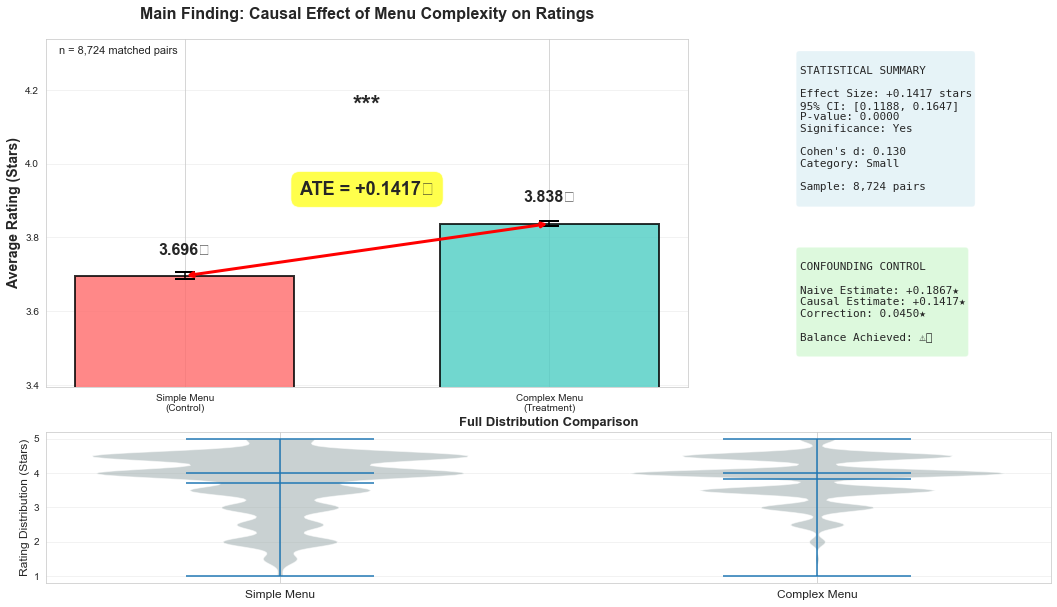

Executive summary created


In [4]:
# Cell 3: Create Executive Summary Visualization
print("Creating executive summary visualization...")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Main finding - Large center plot
ax_main = fig.add_subplot(gs[0:2, 0:2])

ate = results['ate']
ci_lower = results['ate_ci_lower']
ci_upper = results['ate_ci_upper']
p_value = results['p_value']

# Bar chart with error bars
categories = ['Simple Menu\n(Control)', 'Complex Menu\n(Treatment)']
simple_mean = df_matched[df_matched['complex_menu']==0]['stars'].mean()
complex_mean = df_matched[df_matched['complex_menu']==1]['stars'].mean()
means = [simple_mean, complex_mean]

bars = ax_main.bar(categories, means, 
                   color=[COLORS['simple'], COLORS['complex']], 
                   edgecolor='black', linewidth=2, alpha=0.8, width=0.6)

# Add error bars (using standard error)
simple_se = df_matched[df_matched['complex_menu']==0]['stars'].std() / np.sqrt(len(df_matched[df_matched['complex_menu']==0]))
complex_se = df_matched[df_matched['complex_menu']==1]['stars'].std() / np.sqrt(len(df_matched[df_matched['complex_menu']==1]))
ax_main.errorbar(range(2), means, yerr=[simple_se, complex_se], 
                 fmt='none', ecolor='black', capsize=10, capthick=2)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, means)):
    ax_main.text(bar.get_x() + bar.get_width()/2, val + 0.05, 
                f'{val:.3f}★', ha='center', va='bottom', 
                fontsize=16, fontweight='bold')

# Add ATE annotation
mid_x = 0.5
mid_y = (simple_mean + complex_mean) / 2
ax_main.annotate('', xy=(1, complex_mean), xytext=(0, simple_mean),
                arrowprops=dict(arrowstyle='<->', color='red', lw=3))
ax_main.text(mid_x, mid_y + 0.15, f'ATE = {ate:+.4f}★', 
            ha='center', fontsize=18, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

# Significance indicator
sig_text = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "n.s."
ax_main.text(mid_x, max(means) + 0.3, sig_text, 
            ha='center', fontsize=24, fontweight='bold')

ax_main.set_ylabel('Average Rating (Stars)', fontsize=14, fontweight='bold')
ax_main.set_title('Main Finding: Causal Effect of Menu Complexity on Ratings', 
                 fontsize=16, fontweight='bold', pad=20)
ax_main.set_ylim([min(means) - 0.3, max(means) + 0.5])
ax_main.grid(True, alpha=0.3, axis='y')

# Sample size box
ax_main.text(0.02, 0.98, f'n = {results["sample_size_matched"]:,} matched pairs', 
            transform=ax_main.transAxes, fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Top right: Statistical summary
ax_stats = fig.add_subplot(gs[0, 2])
ax_stats.axis('off')

stats_text = f"""
STATISTICAL SUMMARY

Effect Size: {ate:+.4f} stars
95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]
P-value: {p_value:.4f}
Significance: {'Yes' if p_value < 0.05 else '✗ No'}

Cohen's d: {results['cohens_d']:.3f}
Category: {results['effect_size_category'].title()}

Sample: {results['sample_size_matched']:,} pairs
"""

ax_stats.text(0.1, 0.9, stats_text, fontsize=11, verticalalignment='top',
             family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Middle right: Key metrics
ax_metrics = fig.add_subplot(gs[1, 2])
ax_metrics.axis('off')

# Confounding correction
correction = results['confounding_correction']
naive_ate = results['naive_ate']

metrics_text = f"""
CONFOUNDING CONTROL

Naive Estimate: {naive_ate:+.4f}★
Causal Estimate: {ate:+.4f}★
Correction: {correction:.4f}★

Balance Achieved: {'✓' if all(abs(balance_after['After_StdDiff']) < 0.1) else '⚠️'}
"""

ax_metrics.text(0.1, 0.9, metrics_text, fontsize=11, verticalalignment='top',
               family='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

# Bottom: Distribution comparison
ax_dist = fig.add_subplot(gs[2, :])

simple_data = df_matched[df_matched['complex_menu']==0]['stars']
complex_data = df_matched[df_matched['complex_menu']==1]['stars']

# Violin plots
parts = ax_dist.violinplot([simple_data, complex_data], 
                           positions=[1, 2], 
                           showmeans=True, showmedians=True, widths=0.7)

for pc in parts['bodies']:
    pc.set_facecolor(COLORS['neutral'])
    pc.set_alpha(0.5)

ax_dist.set_xticks([1, 2])
ax_dist.set_xticklabels(['Simple Menu', 'Complex Menu'], fontsize=12)
ax_dist.set_ylabel('Rating Distribution (Stars)', fontsize=12)
ax_dist.set_title('Full Distribution Comparison', fontsize=13, fontweight='bold')
ax_dist.grid(True, alpha=0.3, axis='y')

plt.savefig('outputs/figures/executive_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Executive summary created")

Creating methodology flow diagram...


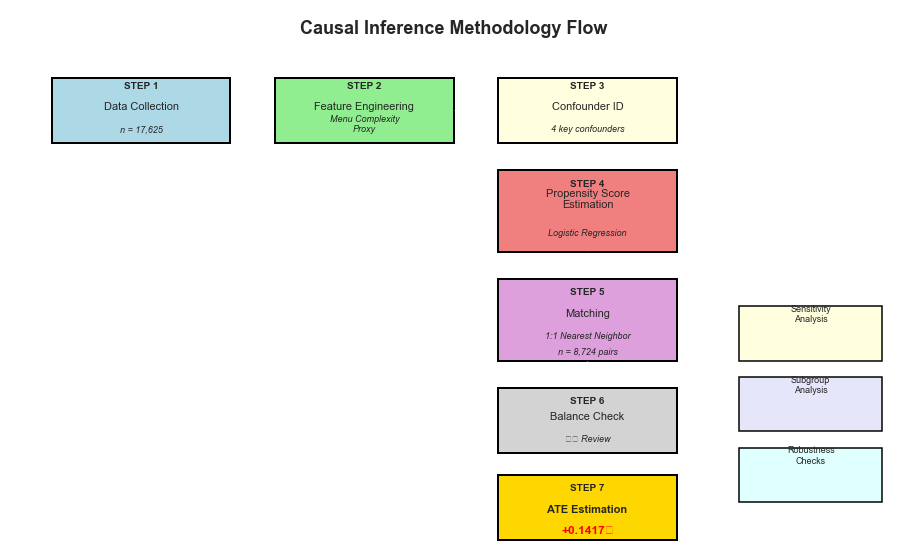

Methodology flow diagram created


In [5]:
# Cell 4: Create Methodology Flow Diagram
print("Creating methodology flow diagram...")

fig, axes = plt.subplots(1, 1, figsize=(16, 10))
ax = axes
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(5, 9.5, 'Causal Inference Methodology Flow', 
       ha='center', fontsize=18, fontweight='bold')

# Step 1: Data Collection
ax.add_patch(plt.Rectangle((0.5, 7.5), 2, 1.2, 
                           facecolor='lightblue', edgecolor='black', linewidth=2))
ax.text(1.5, 8.5, 'STEP 1', ha='center', fontsize=10, fontweight='bold')
ax.text(1.5, 8.1, 'Data Collection', ha='center', fontsize=11)
ax.text(1.5, 7.7, f'n = {len(df_original):,}', ha='center', fontsize=9, style='italic')

# Arrow
ax.annotate('', xy=(3, 8.1), xytext=(2.5, 8.1),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 2: Feature Engineering
ax.add_patch(plt.Rectangle((3, 7.5), 2, 1.2,
                           facecolor='lightgreen', edgecolor='black', linewidth=2))
ax.text(4, 8.5, 'STEP 2', ha='center', fontsize=10, fontweight='bold')
ax.text(4, 8.1, 'Feature Engineering', ha='center', fontsize=11)
ax.text(4, 7.7, 'Menu Complexity\nProxy', ha='center', fontsize=9, style='italic')

# Arrow
ax.annotate('', xy=(5.5, 8.1), xytext=(5, 8.1),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 3: EDA
ax.add_patch(plt.Rectangle((5.5, 7.5), 2, 1.2,
                           facecolor='lightyellow', edgecolor='black', linewidth=2))
ax.text(6.5, 8.5, 'STEP 3', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 8.1, 'Confounder ID', ha='center', fontsize=11)
ax.text(6.5, 7.7, '4 key confounders', ha='center', fontsize=9, style='italic')

# Arrow down
ax.annotate('', xy=(6.5, 7.3), xytext=(6.5, 7.5),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 4: Propensity Scores
ax.add_patch(plt.Rectangle((5.5, 5.5), 2, 1.5,
                           facecolor='lightcoral', edgecolor='black', linewidth=2))
ax.text(6.5, 6.7, 'STEP 4', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 6.3, 'Propensity Score\nEstimation', ha='center', fontsize=11)
ax.text(6.5, 5.8, 'Logistic Regression', ha='center', fontsize=9, style='italic')

# Arrow down
ax.annotate('', xy=(6.5, 5.3), xytext=(6.5, 5.5),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 5: Matching
ax.add_patch(plt.Rectangle((5.5, 3.5), 2, 1.5,
                           facecolor='plum', edgecolor='black', linewidth=2))
ax.text(6.5, 4.7, 'STEP 5', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 4.3, 'Matching', ha='center', fontsize=11)
ax.text(6.5, 3.9, f'1:1 Nearest Neighbor', ha='center', fontsize=9, style='italic')
ax.text(6.5, 3.6, f'n = {results["sample_size_matched"]:,} pairs', 
       ha='center', fontsize=9, style='italic')

# Arrow down
ax.annotate('', xy=(6.5, 3.3), xytext=(6.5, 3.5),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 6: Balance Check
ax.add_patch(plt.Rectangle((5.5, 1.8), 2, 1.2,
                           facecolor='lightgray', edgecolor='black', linewidth=2))
ax.text(6.5, 2.7, 'STEP 6', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 2.4, 'Balance Check', ha='center', fontsize=11)
balance_status = 'Balanced' if all(abs(balance_after['After_StdDiff']) < 0.1) else '⚠️ Review'
ax.text(6.5, 2.0, balance_status, ha='center', fontsize=9, style='italic')

# Arrow down
ax.annotate('', xy=(6.5, 1.6), xytext=(6.5, 1.8),
           arrowprops=dict(arrowstyle='->', lw=2))

# Step 7: ATE Estimation
ax.add_patch(plt.Rectangle((5.5, 0.2), 2, 1.2,
                           facecolor='gold', edgecolor='black', linewidth=2))
ax.text(6.5, 1.1, 'STEP 7', ha='center', fontsize=10, fontweight='bold')
ax.text(6.5, 0.7, 'ATE Estimation', ha='center', fontsize=11, fontweight='bold')
ax.text(6.5, 0.3, f'{ate:+.4f}★', ha='center', fontsize=12, 
       fontweight='bold', color='red')

# Side branches for robustness
# Sensitivity Analysis
ax.add_patch(plt.Rectangle((8.2, 3.5), 1.6, 1,
                           facecolor='lightyellow', edgecolor='black', linewidth=1.5))
ax.text(9, 4.2, 'Sensitivity\nAnalysis', ha='center', fontsize=9)

ax.annotate('', xy=(8.2, 4), xytext=(7.5, 4),
           arrowprops=dict(arrowstyle='->', lw=1.5, linestyle='--'))

# Subgroup Analysis
ax.add_patch(plt.Rectangle((8.2, 2.2), 1.6, 1,
                           facecolor='lavender', edgecolor='black', linewidth=1.5))
ax.text(9, 2.9, 'Subgroup\nAnalysis', ha='center', fontsize=9)

ax.annotate('', xy=(8.2, 2.7), xytext=(7.5, 2.7),
           arrowprops=dict(arrowstyle='->', lw=1.5, linestyle='--'))

# Methods Comparison
ax.add_patch(plt.Rectangle((8.2, 0.9), 1.6, 1,
                           facecolor='lightcyan', edgecolor='black', linewidth=1.5))
ax.text(9, 1.6, 'Robustness\nChecks', ha='center', fontsize=9)

ax.annotate('', xy=(8.2, 1.4), xytext=(7.5, 1.4),
           arrowprops=dict(arrowstyle='->', lw=1.5, linestyle='--'))

plt.savefig('outputs/figures/methodology_flow.png', dpi=300, bbox_inches='tight')
plt.show()

print("Methodology flow diagram created")

Creating comprehensive results dashboard...


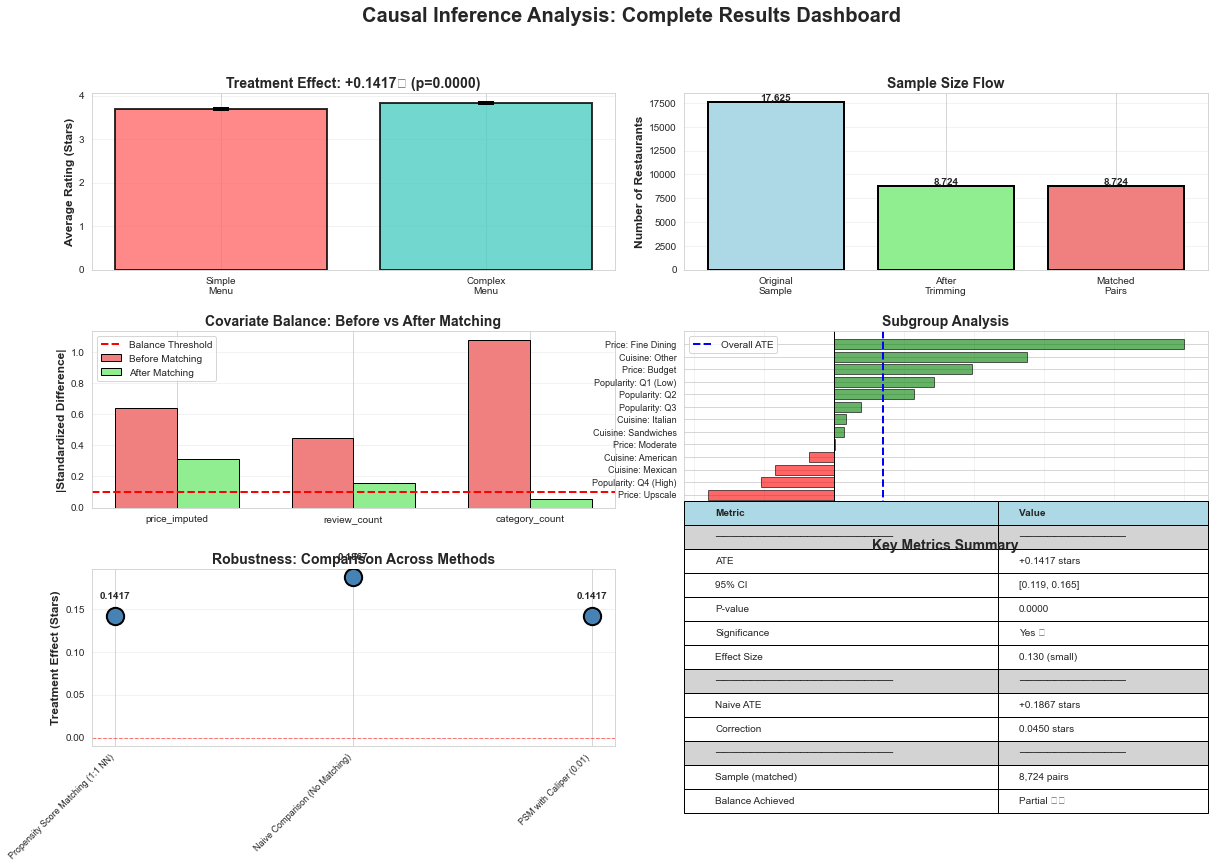

Results dashboard created


In [6]:
# Cell 5: Create Comprehensive Results Dashboard (FIXED)
print("Creating comprehensive results dashboard...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.3)

# Title
fig.suptitle('Causal Inference Analysis: Complete Results Dashboard', 
            fontsize=20, fontweight='bold', y=0.98)

# Plot 1: Main Effect with CI
ax1 = fig.add_subplot(gs[0, 0:2])
x = ['Simple\nMenu', 'Complex\nMenu']
y = [df_matched[df_matched['complex_menu']==0]['stars'].mean(),
     df_matched[df_matched['complex_menu']==1]['stars'].mean()]

ax1.bar(x, y, color=[COLORS['simple'], COLORS['complex']], 
       edgecolor='black', linewidth=2, alpha=0.8)
ax1.errorbar([0, 1], y, 
            yerr=[ci_upper - ate, ci_upper - ate], 
            fmt='none', ecolor='black', capsize=8, capthick=2)
ax1.set_ylabel('Average Rating (Stars)', fontweight='bold')
ax1.set_title(f'Treatment Effect: {ate:+.4f}★ (p={p_value:.4f})', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Sample sizes
ax2 = fig.add_subplot(gs[0, 2:4])
sample_stages = ['Original\nSample', 'After\nTrimming', 'Matched\nPairs']
sample_sizes = [len(df_original), len(df_matched)//2, results['sample_size_matched']]
colors_samples = ['lightblue', 'lightgreen', 'lightcoral']

bars = ax2.bar(sample_stages, sample_sizes, color=colors_samples, 
              edgecolor='black', linewidth=2)
for bar, size in zip(bars, sample_sizes):
    ax2.text(bar.get_x() + bar.get_width()/2, size + 200, 
            f'{size:,}', ha='center', fontweight='bold')

ax2.set_ylabel('Number of Restaurants', fontweight='bold')
ax2.set_title('Sample Size Flow', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Balance improvement (FIXED)
ax3 = fig.add_subplot(gs[1, 0:2])

# Check what columns we actually have
if 'Before_StdDiff' in balance_after.columns and 'After_StdDiff' in balance_after.columns:
    # balance_after has both before and after
    variables = balance_after['Variable'].values
    before = np.abs(balance_after['Before_StdDiff'].values)
    after = np.abs(balance_after['After_StdDiff'].values)
else:
    # We need to compute before/after from the two separate files
    # Merge balance_before and balance_after by Variable
    variables = balance_after['Variable'].values
    
    # Get standardized differences from each file
    # balance_before should have 'Std. Diff' column
    # balance_after should have 'After_StdDiff' column
    before_dict = dict(zip(balance_before['Covariate'], balance_before['Std. Diff']))
    after_dict = dict(zip(balance_after['Variable'], balance_after['After_StdDiff']))
    
    # Match them up
    before = np.array([abs(before_dict.get(var, 0)) for var in variables])
    after = np.array([abs(after_dict.get(var, 0)) for var in variables])

x_pos = np.arange(len(variables))
width = 0.35

ax3.bar(x_pos - width/2, before, width, label='Before Matching', 
       color='lightcoral', edgecolor='black')
ax3.bar(x_pos + width/2, after, width, label='After Matching',
       color='lightgreen', edgecolor='black')
ax3.axhline(0.1, color='red', linestyle='--', linewidth=2, label='Balance Threshold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(variables, rotation=0)
ax3.set_ylabel('|Standardized Difference|', fontweight='bold')
ax3.set_title('Covariate Balance: Before vs After Matching', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Subgroup effects
ax4 = fig.add_subplot(gs[1, 2:4])
subgroup_plot = subgroup_results.copy()
subgroup_plot = subgroup_plot.sort_values('ATE')

colors_subgroup = ['red' if x < 0 else 'green' for x in subgroup_plot['ATE']]
ax4.barh(range(len(subgroup_plot)), subgroup_plot['ATE'], 
        color=colors_subgroup, alpha=0.6, edgecolor='black')
ax4.set_yticks(range(len(subgroup_plot)))
ax4.set_yticklabels(subgroup_plot['Subgroup'], fontsize=9)
ax4.set_xlabel('Treatment Effect (Stars)', fontweight='bold')
ax4.set_title('Subgroup Analysis', fontweight='bold')
ax4.axvline(0, color='black', linewidth=1)
ax4.axvline(ate, color='blue', linestyle='--', linewidth=2, label='Overall ATE')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Methods comparison
ax5 = fig.add_subplot(gs[2, 0:2])
methods_plot = methods_comparison[methods_comparison['P-value'].notna()].copy()
x_methods = range(len(methods_plot))

ax5.scatter(x_methods, methods_plot['ATE'], s=300, color='steelblue', 
           edgecolor='black', linewidth=2, zorder=3)
ax5.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

for i, (idx, row) in enumerate(methods_plot.iterrows()):
    ax5.text(i, row['ATE'] + 0.02, f"{row['ATE']:.4f}", 
            ha='center', fontweight='bold')

ax5.set_xticks(x_methods)
ax5.set_xticklabels(methods_plot['Method'], rotation=45, ha='right', fontsize=9)
ax5.set_ylabel('Treatment Effect (Stars)', fontweight='bold')
ax5.set_title('Robustness: Comparison Across Methods', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Key metrics table
ax6 = fig.add_subplot(gs[2, 2:4])
ax6.axis('off')

# Check balance achievement
balance_achieved = all(abs(balance_after['After_StdDiff']) < 0.1)

metrics_data = [
    ['Metric', 'Value'],
    ['─'*25, '─'*15],
    ['ATE', f'{ate:+.4f} stars'],
    ['95% CI', f'[{ci_lower:.3f}, {ci_upper:.3f}]'],
    ['P-value', f'{p_value:.4f}'],
    ['Significance', 'Yes ✓' if p_value < 0.05 else 'No ✗'],
    ['Effect Size', f"{results['cohens_d']:.3f} ({results['effect_size_category']})"],
    ['─'*25, '─'*15],
    ['Naive ATE', f'{naive_ate:+.4f} stars'],
    ['Correction', f'{correction:.4f} stars'],
    ['─'*25, '─'*15],
    ['Sample (matched)', f"{results['sample_size_matched']:,} pairs"],
    ['Balance Achieved', 'Yes ✓' if balance_achieved else 'Partial ⚠️']
]

table = ax6.table(cellText=metrics_data, cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('lightblue')
    table[(0, i)].set_text_props(weight='bold')

# Style divider rows
for row in [1, 7, 10]:
    for col in range(2):
        table[(row, col)].set_facecolor('lightgray')

ax6.set_title('Key Metrics Summary', fontweight='bold', pad=20)

plt.savefig('outputs/figures/results_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Results dashboard created")

Creating business recommendations visual...


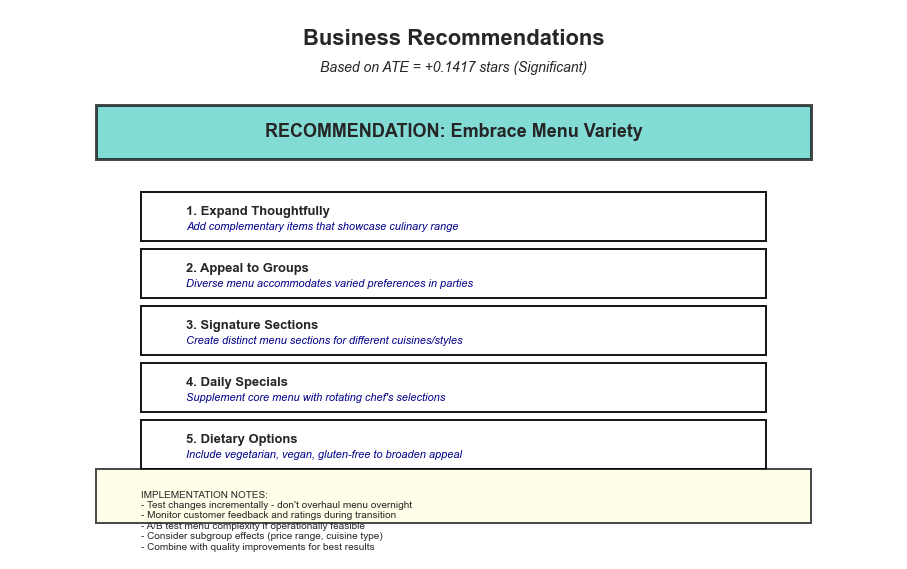

Business recommendations visual created


In [7]:
# Cell 6: Business Recommendations Visual
print("Creating business recommendations visual...")

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Title
ax.text(5, 9.3, 'Business Recommendations', 
       ha='center', fontsize=22, fontweight='bold')
ax.text(5, 8.8, f'Based on ATE = {ate:+.4f} stars ({"Significant" if p_value < 0.05 else "Not Significant"})',
       ha='center', fontsize=14, style='italic')

# Determine recommendation based on results
if ate < -0.05 and p_value < 0.05:
    # Complex menus hurt ratings
    recommendation_title = "RECOMMENDATION: Simplify Menus"
    recommendation_color = COLORS['simple']
    
    recommendations = [
        ("1. Focus on Fewer Items", 
         "Concentrate on executing 15-25 signature dishes exceptionally well"),
        ("2. Streamline Categories",
         "Reduce menu sections to 3-4 main categories for clarity"),
        ("3. Highlight Specialties",
         "Make best dishes prominent - quality over quantity"),
        ("4. Seasonal Rotation",
         "Instead of extensive permanent menu, rotate seasonal specials"),
        ("5. Staff Training",
         "Simpler menu allows better product knowledge and service")
    ]
    
elif ate > 0.05 and p_value < 0.05:
    # Complex menus help ratings
    recommendation_title = "RECOMMENDATION: Embrace Menu Variety"
    recommendation_color = COLORS['complex']
    
    recommendations = [
        ("1. Expand Thoughtfully",
         "Add complementary items that showcase culinary range"),
        ("2. Appeal to Groups",
         "Diverse menu accommodates varied preferences in parties"),
        ("3. Signature Sections",
         "Create distinct menu sections for different cuisines/styles"),
        ("4. Daily Specials",
         "Supplement core menu with rotating chef's selections"),
        ("5. Dietary Options",
         "Include vegetarian, vegan, gluten-free to broaden appeal")
    ]
    
else:
    # No significant effect
    recommendation_title = "RECOMMENDATION: Focus on Quality, Not Complexity"
    recommendation_color = COLORS['neutral']
    
    recommendations = [
        ("1. Prioritize Execution",
         "Menu size doesn't drive ratings - focus on food quality"),
        ("2. Operational Efficiency",
         "Choose menu complexity based on kitchen capabilities"),
        ("3. Service Excellence",
         "Invest in staff training and customer experience"),
        ("4. Ingredient Quality",
         "Source premium ingredients regardless of menu size"),
        ("5. Consistency Focus",
         "Ensure every dish meets high standards every time")
    ]

# Main recommendation box
ax.add_patch(plt.Rectangle((1, 7.2), 8, 1,
                           facecolor=recommendation_color, 
                           edgecolor='black', linewidth=3, alpha=0.7))
ax.text(5, 7.7, recommendation_title,
       ha='center', va='center', fontsize=18, fontweight='bold')

# Individual recommendations
y_start = 6.5
box_height = 0.9
spacing = 0.15

for i, (title, description) in enumerate(recommendations):
    y_pos = y_start - i * (box_height + spacing)
    
    # Box
    ax.add_patch(plt.Rectangle((1.5, y_pos - box_height + 0.1), 7, box_height,
                               facecolor='white', edgecolor='black', 
                               linewidth=2, alpha=0.9))
    
    # Title
    ax.text(2, y_pos - 0.15, title,
           fontsize=13, fontweight='bold', va='top')
    
    # Description
    ax.text(2, y_pos - 0.45, description,
           fontsize=11, va='top', style='italic', color='darkblue')

# Bottom box: Implementation notes
ax.add_patch(plt.Rectangle((1, 0.5), 8, 1,
                           facecolor='lightyellow', edgecolor='black', 
                           linewidth=2, alpha=0.7))

implementation_text = """
IMPLEMENTATION NOTES:
- Test changes incrementally - don't overhaul menu overnight
- Monitor customer feedback and ratings during transition
- A/B test menu complexity if operationally feasible  
- Consider subgroup effects (price range, cuisine type)
- Combine with quality improvements for best results
"""

ax.text(1.5, 1.3, implementation_text,
       fontsize=10, va='top', family='sans-serif')

plt.savefig('outputs/figures/business_recommendations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Business recommendations visual created")

Creating limitations summary...


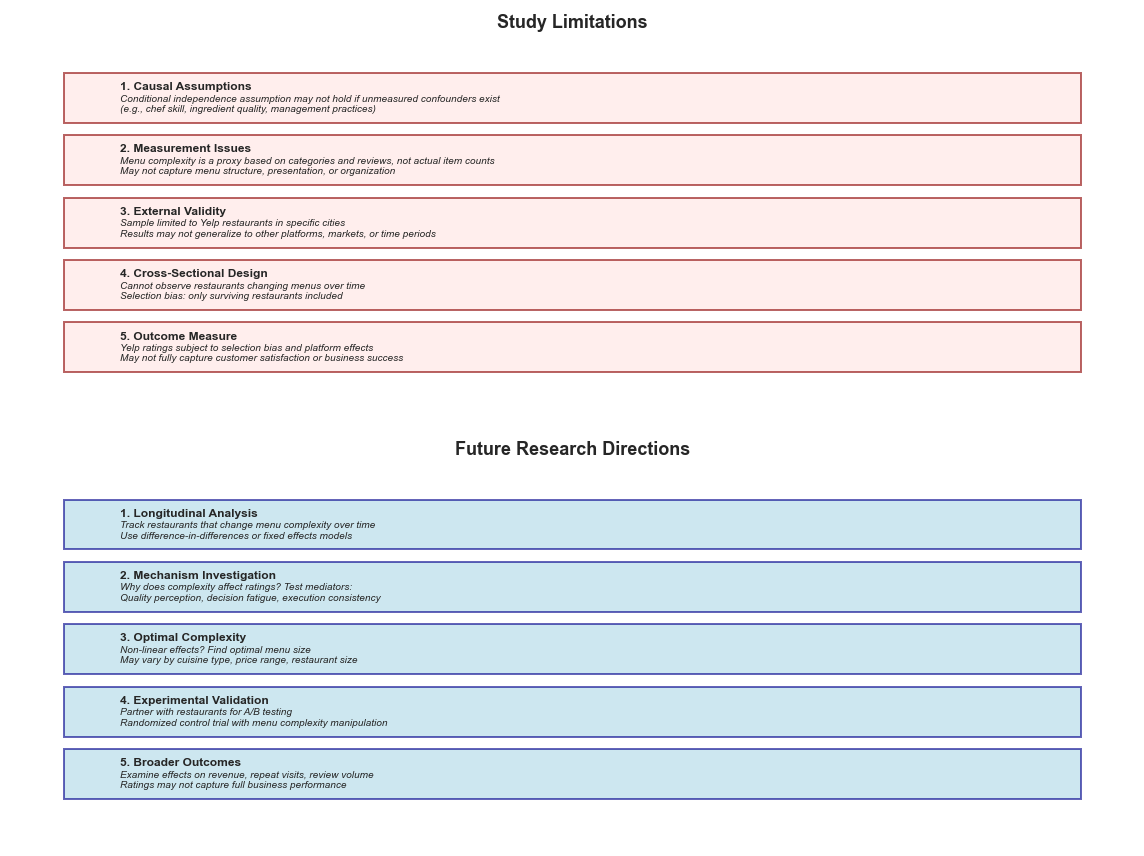

Limitations and future research visual created


In [8]:
# Cell 7: Limitations and Future Research
print("Creating limitations summary...")

fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Limitations
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')

ax1.text(5, 9.5, 'Study Limitations', 
        ha='center', fontsize=18, fontweight='bold')

limitations = [
    ("1. Causal Assumptions",
     "Conditional independence assumption may not hold if unmeasured confounders exist\n"
     "(e.g., chef skill, ingredient quality, management practices)"),
    
    ("2. Measurement Issues",
     "Menu complexity is a proxy based on categories and reviews, not actual item counts\n"
     "May not capture menu structure, presentation, or organization"),
    
    ("3. External Validity",
     "Sample limited to Yelp restaurants in specific cities\n"
     "Results may not generalize to other platforms, markets, or time periods"),
    
    ("4. Cross-Sectional Design",
     "Cannot observe restaurants changing menus over time\n"
     "Selection bias: only surviving restaurants included"),
    
    ("5. Outcome Measure",
     "Yelp ratings subject to selection bias and platform effects\n"
     "May not fully capture customer satisfaction or business success")
]

y_pos = 8.5
for i, (title, desc) in enumerate(limitations):
    ax1.add_patch(plt.Rectangle((0.5, y_pos - 1.3), 9, 1.2,
                                facecolor='mistyrose', edgecolor='darkred',
                                linewidth=2, alpha=0.6))
    
    ax1.text(1, y_pos - 0.3, title,
            fontsize=12, fontweight='bold', va='top')
    ax1.text(1, y_pos - 0.6, desc,
            fontsize=10, va='top', style='italic', wrap=True)
    
    y_pos -= 1.5

# Future Research
ax2 = axes[1]
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')

ax2.text(5, 9.5, 'Future Research Directions', 
        ha='center', fontsize=18, fontweight='bold')

future_research = [
    ("1. Longitudinal Analysis",
     "Track restaurants that change menu complexity over time\n"
     "Use difference-in-differences or fixed effects models"),
    
    ("2. Mechanism Investigation",
     "Why does complexity affect ratings? Test mediators:\n"
     "Quality perception, decision fatigue, execution consistency"),
    
    ("3. Optimal Complexity",
     "Non-linear effects? Find optimal menu size\n"
     "May vary by cuisine type, price range, restaurant size"),
    
    ("4. Experimental Validation",
     "Partner with restaurants for A/B testing\n"
     "Randomized control trial with menu complexity manipulation"),
    
    ("5. Broader Outcomes",
     "Examine effects on revenue, repeat visits, review volume\n"
     "Ratings may not capture full business performance")
]

y_pos = 8.5
for i, (title, desc) in enumerate(future_research):
    ax2.add_patch(plt.Rectangle((0.5, y_pos - 1.3), 9, 1.2,
                                facecolor='lightblue', edgecolor='darkblue',
                                linewidth=2, alpha=0.6))
    
    ax2.text(1, y_pos - 0.3, title,
            fontsize=12, fontweight='bold', va='top')
    ax2.text(1, y_pos - 0.6, desc,
            fontsize=10, va='top', style='italic')
    
    y_pos -= 1.5

plt.tight_layout()
plt.savefig('outputs/figures/limitations_and_future_research.png', dpi=300, bbox_inches='tight')
plt.show()

print("Limitations and future research visual created")

Creating one-page summary for presentation...


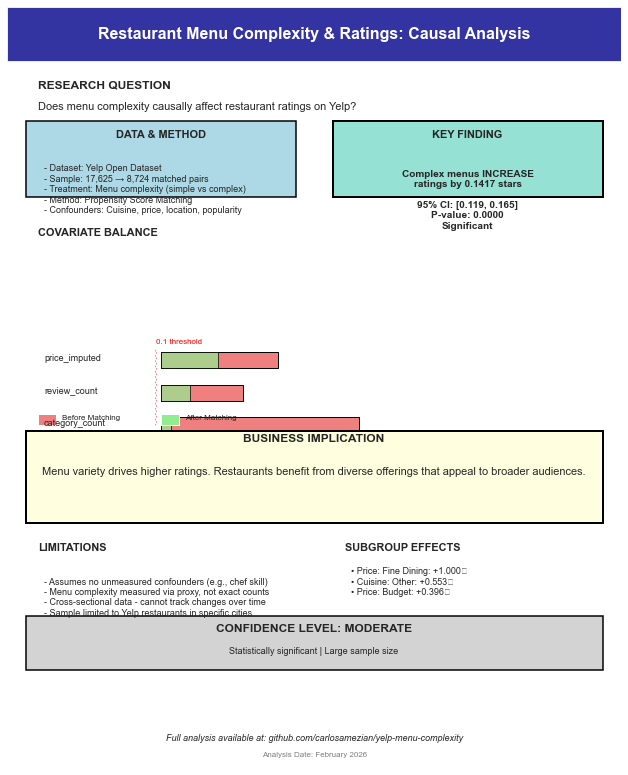

One-page summary created


In [10]:
# Cell 8: Create Final One-Page Summary
print("Creating one-page summary for presentation...")

fig = plt.figure(figsize=(11, 14))  # Letter size
ax = fig.add_subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(0, 14)
ax.axis('off')

# Header
ax.add_patch(plt.Rectangle((0, 13), 10, 1,
                           facecolor='darkblue', alpha=0.8))
ax.text(5, 13.5, 'Restaurant Menu Complexity & Ratings: Causal Analysis',
       ha='center', va='center', fontsize=16, fontweight='bold', color='white')

# Research Question
ax.text(0.5, 12.5, 'RESEARCH QUESTION',
       fontsize=12, fontweight='bold')
ax.text(0.5, 12.1, 'Does menu complexity causally affect restaurant ratings on Yelp?',
       fontsize=11)

# Data & Method
ax.add_patch(plt.Rectangle((0.3, 10.5), 4.4, 1.4,
                           facecolor='lightblue', edgecolor='black', linewidth=1.5))
ax.text(2.5, 11.6, 'DATA & METHOD', ha='center', fontsize=11, fontweight='bold')
method_text = f"""
- Dataset: Yelp Open Dataset
- Sample: {len(df_original):,} → {results['sample_size_matched']:,} matched pairs
- Treatment: Menu complexity (simple vs complex)
- Method: Propensity Score Matching
- Confounders: Cuisine, price, location, popularity
"""
ax.text(0.6, 11.3, method_text, fontsize=9, va='top')

# Key Finding
ate = results['ate']
ci_lower = results['ate_ci_lower']
ci_upper = results['ate_ci_upper']
p_value = results['p_value']

finding_color = COLORS['positive'] if ate > 0 else COLORS['negative'] if ate < 0 else COLORS['neutral']
ax.add_patch(plt.Rectangle((5.3, 10.5), 4.4, 1.4,
                           facecolor=finding_color, edgecolor='black', linewidth=2))
ax.text(7.5, 11.6, 'KEY FINDING', ha='center', fontsize=11, fontweight='bold')

direction = "INCREASE" if ate > 0 else "DECREASE" if ate < 0 else "NO CHANGE IN"
finding_text = f"""
Complex menus {direction}
ratings by {abs(ate):.4f} stars

95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]
P-value: {p_value:.4f}
{'Significant' if p_value < 0.05 else '✗ Not Significant'}
"""
ax.text(7.5, 11.2, finding_text, ha='center', fontsize=10, va='top', fontweight='bold')

# Visual: Before/After Matching Balance
ax.text(0.5, 9.8, 'COVARIATE BALANCE', fontsize=11, fontweight='bold')
balance_viz_y = 7.5

# Get balance data
if 'Before_StdDiff' in balance_after.columns:
    balance_vars = balance_after['Variable'].values
    before_stds = balance_after['Before_StdDiff'].values
    after_stds = balance_after['After_StdDiff'].values
else:
    # Merge from separate files
    before_dict = dict(zip(balance_before['Covariate'], balance_before['Std. Diff']))
    balance_vars = balance_after['Variable'].values
    before_stds = np.array([before_dict.get(var, 0) for var in balance_vars])
    after_stds = balance_after['After_StdDiff'].values

for i, (var, before_std, after_std) in enumerate(zip(balance_vars, before_stds, after_stds)):
    y = balance_viz_y - i*0.6
    ax.text(0.6, y, var, fontsize=9)
    
    # Before bar
    ax.add_patch(plt.Rectangle((2.5, y-0.15), abs(before_std)*3, 0.3,
                               facecolor='lightcoral', edgecolor='black'))
    # After bar
    ax.add_patch(plt.Rectangle((2.5, y-0.15), abs(after_std)*3, 0.3,
                               facecolor='lightgreen', edgecolor='black', alpha=0.7))

ax.add_patch(plt.Rectangle((2.4, balance_viz_y + 0.2), 0.02, -len(balance_vars)*0.6 + 0.4,
                           facecolor='red', linestyle='--'))
ax.text(2.42, balance_viz_y + 0.3, '0.1 threshold', fontsize=8, color='red')

# Legend
ax.add_patch(plt.Rectangle((0.5, 6.3), 0.3, 0.2, facecolor='lightcoral'))
ax.text(0.9, 6.4, 'Before Matching', fontsize=8)
ax.add_patch(plt.Rectangle((2.5, 6.3), 0.3, 0.2, facecolor='lightgreen'))
ax.text(2.9, 6.4, 'After Matching', fontsize=8)

# Business Implication
ax.add_patch(plt.Rectangle((0.3, 4.5), 9.4, 1.7,
                           facecolor='lightyellow', edgecolor='black', linewidth=2))
ax.text(5, 6, 'BUSINESS IMPLICATION', ha='center', fontsize=12, fontweight='bold')

if ate < -0.05 and p_value < 0.05:
    implication = "Simpler menus lead to higher ratings. Restaurants should focus on executing fewer items exceptionally well."
elif ate > 0.05 and p_value < 0.05:
    implication = "Menu variety drives higher ratings. Restaurants benefit from diverse offerings that appeal to broader audiences."
else:
    implication = "Menu complexity doesn't significantly impact ratings. Focus on food quality, service, and consistency instead."

ax.text(5, 5.4, implication, ha='center', fontsize=11, wrap=True)

# Limitations
ax.text(0.5, 4, 'LIMITATIONS', fontsize=11, fontweight='bold')
limitations_text = """
- Assumes no unmeasured confounders (e.g., chef skill)
- Menu complexity measured via proxy, not exact counts
- Cross-sectional data - cannot track changes over time
- Sample limited to Yelp restaurants in specific cities
"""
ax.text(0.6, 3.7, limitations_text, fontsize=9, va='top')

# Subgroup Insights
ax.text(5.5, 4, 'SUBGROUP EFFECTS', fontsize=11, fontweight='bold')
# Show top 3 subgroups with largest effects
top_subgroups = subgroup_results.nlargest(3, 'ATE', keep='first')
subgroup_text = ""
for _, row in top_subgroups.iterrows():
    subgroup_text += f"• {row['Subgroup']}: {row['ATE']:+.3f}★\n"
ax.text(5.6, 3.7, subgroup_text, fontsize=9, va='top')

# Confidence Statement
ax.add_patch(plt.Rectangle((0.3, 1.8), 9.4, 1,
                           facecolor='lightgray', edgecolor='black', linewidth=1.5))
balance_achieved = all(abs(balance_after['After_StdDiff']) < 0.1)
confidence = "HIGH" if p_value < 0.01 and balance_achieved else \
             "MODERATE" if p_value < 0.05 else "LOW"
ax.text(5, 2.5, f'CONFIDENCE LEVEL: {confidence}', 
       ha='center', fontsize=12, fontweight='bold')
confidence_reasons = []
if p_value < 0.05:
    confidence_reasons.append("Statistically significant")
if balance_achieved:
    confidence_reasons.append("Good covariate balance")
if results['sample_size_matched'] > 500:
    confidence_reasons.append("Large sample size")

ax.text(5, 2.1, " | ".join(confidence_reasons), ha='center', fontsize=9)

# Footer
ax.text(5, 0.5, 'Full analysis available at: github.com/carlosamezian/yelp-menu-complexity',
       ha='center', fontsize=9, style='italic')
ax.text(5, 0.2, f'Analysis Date: {pd.Timestamp.now().strftime("%B %Y")}',
       ha='center', fontsize=8, color='gray')

plt.savefig('outputs/figures/one_page_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("One-page summary created")